# Problema de Duración de viaje en Taxi

*target*: duracion del viaje  
Problema de **Regresion**

In [1]:
import scipy.io as sio
import scipy as sp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold , metrics, tree
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier as Tree

from keras.models import load_model, Model,Sequential
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.core import Dense, Activation, Dropout

from subprocess import check_call
from IPython.display import Image as PImage

Using TensorFlow backend.


In [2]:
def rmsle(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
#annadir grafico de real vs predecido
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.') #o punto
    
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.title("Compara Valor real con la prediccion")
    plt.show()

### Cargar datos:

In [50]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
print("Dimensiones training set: ", df.shape)
print("Dimensiones test set: ", df_test.shape)

('Dimensiones training set: ', (1458644, 11))
('Dimensiones test set: ', (625134, 9))


### Procesar dataset;

In [5]:
from geopy.distance import great_circle
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

In [51]:
#reemplazar Nan
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')

def preprocesar(df):
    df.fillna(0,inplace=True)

    #transformar fechas a tiempos
    #probar con sumar los segundos
    df['min'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['min'] = pd.to_numeric(df['min'])

    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])

    #procesamiento de fecha(datetime-timestamp) a numeros
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek#0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])

    df['year'] = pd.to_datetime(df['pickup_datetime']).dt.year
    df['year'] = pd.to_numeric(df['year'])

    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])

    #caract agregada:
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude']))

    nueva_distancia = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km']=nueva_distancia

    #agregar direccion (en base a grado)
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    #viajes largos
    #df['viaje_largo'] = np.mean(df['distancia_viaje']) < df['distancia_viaje']

    #agregar temporada
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]
    
    #holidays
    df['holiday'] = df['pickup_datetime'].isin(holidays)
    
    ##eliminar columna
    #df.drop("pickup_datetime", inplace=True)
    #df.drop("dropoff_datetime", inplace=True)
    
    #a categorico
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype('category')
    df["holiday"] = df["holiday"].astype('category')

    #codifica
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

preprocesar(df)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,min,hour,cday,year,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,24,17,0,2016,3,0.017680,1.498943,99.970196,1,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,43,0,6,2016,6,0.020456,1.806016,242.846232,2,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,35,11,1,2016,1,0.059934,6.386897,200.319835,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,32,19,2,2016,4,0.013438,1.485917,187.262300,1,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,30,13,5,2016,3,0.010690,1.188923,179.473585,1,0


In [52]:
##eliminar 4 puntos outliers claros
df = df[(df['trip_duration']<=100000)]

In [53]:
all_features = df.columns.values
print all_features

features_red_neuronal = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','store_and_fwd_flag',"min","hour","cday","month", "season",
                     "distancia_viaje","distancia_viaje_km","grado_direccion"]

nuevas_features = ["distancia_viaje", "hour", "dropoff_latitude", "cday","grado_direccion", "vendor_id",
                   "pickup_longitude"]

X = df.loc[:,nuevas_features].values
Y = df.loc[:,'trip_duration'].values

['id' 'vendor_id' 'pickup_datetime' 'dropoff_datetime' 'passenger_count'
 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'store_and_fwd_flag' 'trip_duration' 'min' 'hour'
 'cday' 'year' 'month' 'distancia_viaje' 'distancia_viaje_km'
 'grado_direccion' 'season' 'holiday']


### Crear conjunto de validacion

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print "Tamaño de dataset de entrenamiento: ",X_train.shape
print "Tamaño de dataset de validacion: ",X_val.shape

Tamaño de dataset de entrenamiento:  (1021048, 7)
Tamaño de dataset de validacion:  (437592, 7)


In [21]:
def transformar(valor):
    return np.log(valor+1)

def destransformar(valor):
    epsilon =  1e-15
    pred = np.maximum(epsilon, valor)   
    pred = np.minimum(700,valor)
    return np.exp(pred) -1

def probar_modelo(model,Xtrain,ytrain,Xval,yval):
    print "ERROR RMSLE de training: ", rmsle(model.predict(Xtrain).reshape(1,-1)[0],ytrain)
    print "ERROR RMSLE de validacion: ", rmsle(model.predict(Xval).reshape(1,-1)[0],yval)

    graficar_predicciones(transformar(model.predict(Xval)),transformar(yval))

## Red Neuronal *Feed Forward*

In [32]:
import keras.backend as K

#funcion perdida custom
def error_problema(predicted,real):
    first_log = K.log(K.clip(predicted, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(real, K.epsilon(), None) + 1.)
    valor =  K.mean(K.square(first_log - second_log), axis=-1)
    
    return K.sqrt(valor)

In [11]:
def graficar_historial(hist):
    history_dict = hist.history
    
    loss_values = history_dict['loss']
    if 'val_loss' in history_dict:
        val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    f, axarr = plt.subplots(1, 1, figsize=(14,5) )
    colors = ['#0B9014','#D20BD2']*4
    axarr.plot(epochs, loss_values, 'bo-', label = "Training set")
    if 'val_loss' in history_dict:
        axarr.plot(epochs, val_loss_values, 'g+-', label = "Test set")
    axarr.set_title('Loss de entrenamiento')
    axarr.set_ylim(0)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    axarr.legend(loc="center right", fancybox= True)

    f.tight_layout() #separar los subplot
    plt.show()

### Escalar datos:

In [19]:
#cambiar el sscaler
from sklearn.preprocessing import RobustScaler,StandardScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

sigmoid anda mejor ya que tiene un poder matematico mayor (funcion no lineal puede computar diferentes factores)

In [43]:
#probar red neuronal
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
# model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1,validation_data=(X_test,y_test),callbacks=[stop])

import tensorflow
with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(1000, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

    model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=[error_problema]) #RMSprop, Adam
    historial = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1,
                          validation_data=(X_val_scaled,y_val))

Train on 1021048 samples, validate on 437592 samples
Epoch 1/20
1021048/1021048 [==============================] - 87s - loss: 0.3414 - error_problema: 0.3873 - val_loss: 0.2499 - val_error_problema: 0.3486
Epoch 2/20
1021048/1021048 [==============================] - 83s - loss: 0.2443 - error_problema: 0.3452 - val_loss: 0.2445 - val_error_problema: 0.3443
Epoch 3/20
1021048/1021048 [==============================] - 86s - loss: 0.2412 - error_problema: 0.3428 - val_loss: 0.2419 - val_error_problema: 0.3418
Epoch 4/20
1021048/1021048 [==============================] - 90s - loss: 0.2382 - error_problema: 0.3399 - val_loss: 0.2383 - val_error_problema: 0.3390
Epoch 5/20
1021048/1021048 [==============================] - 90s - loss: 0.2343 - error_problema: 0.3355 - val_loss: 0.2335 - val_error_problema: 0.3335
Epoch 6/20
1021048/1021048 [==============================] - 84s - loss: 0.2299 - error_problema: 0.3304 - val_loss: 0.2301 - val_error_problema: 0.3290
Epoch 7/20
1021048/1021

con optimizador rmsprop


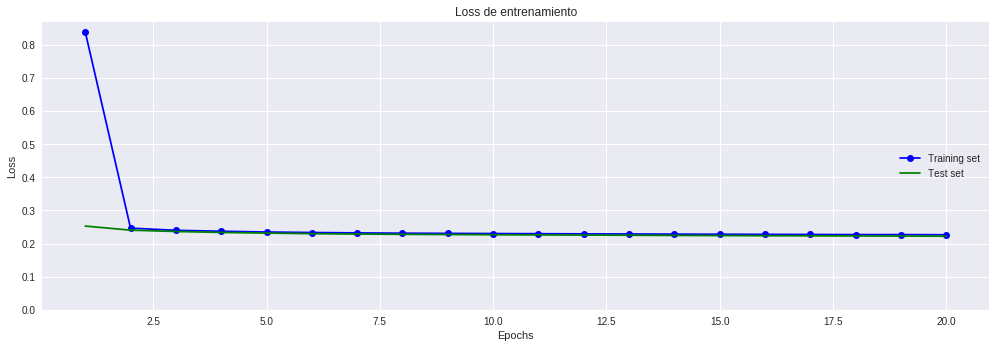

In [42]:
print "con optimizador rmsprop"
graficar_historial(historial)

In [45]:
#agregar mas profundidad

with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.15))
    model.add(Dense(100, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.15))
    #model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

    model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=[error_problema]) #RMSprop, Adam
    history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1,validation_data=(X_val_scaled,y_val))

#relu y sigmoid andan igual 0.42-0.43

Train on 1021048 samples, validate on 437592 samples
Epoch 1/20
1021048/1021048 [==============================] - 65s - loss: 0.7780 - error_problema: 0.5620 - val_loss: 0.2518 - val_error_problema: 0.3510
Epoch 2/20
1021048/1021048 [==============================] - 62s - loss: 0.2409 - error_problema: 0.3416 - val_loss: 0.2193 - val_error_problema: 0.3163
Epoch 3/20
1021048/1021048 [==============================] - 62s - loss: 0.2241 - error_problema: 0.3231 - val_loss: 0.2101 - val_error_problema: 0.3058
Epoch 4/20
1021048/1021048 [==============================] - 62s - loss: 0.2175 - error_problema: 0.3157 - val_loss: 0.2048 - val_error_problema: 0.2999
Epoch 5/20
1021048/1021048 [==============================] - 63s - loss: 0.2143 - error_problema: 0.3117 - val_loss: 0.2016 - val_error_problema: 0.2955
Epoch 6/20
1021048/1021048 [==============================] - 64s - loss: 0.2115 - error_problema: 0.3086 - val_loss: 0.1997 - val_error_problema: 0.2922
Epoch 7/20
1021048/1021

ERROR RMSLE de training:  0.426490851864
ERROR RMSLE de validacion:  0.430020615495


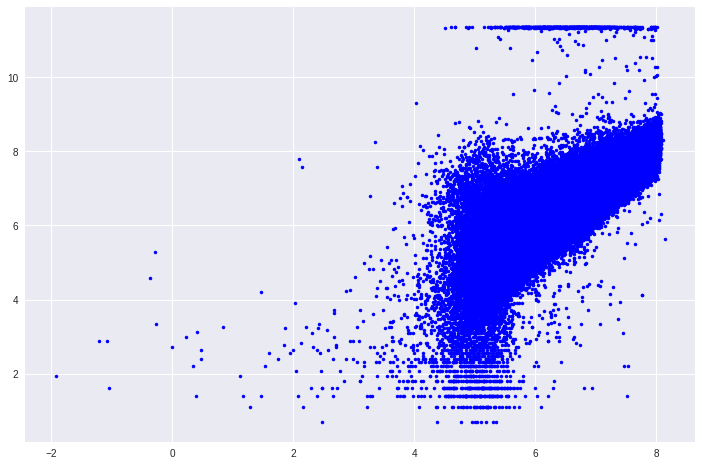

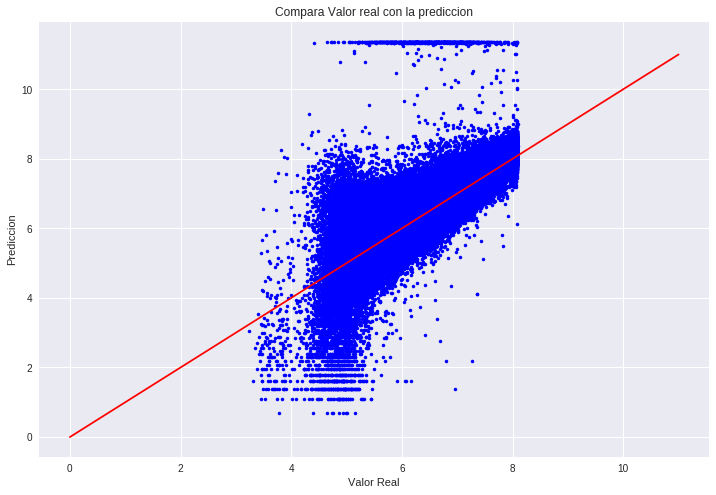

In [46]:
probar_modelo(model,X_train_scaled,y_train,X_val_scaled,y_val)

In [51]:
with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(250, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(250, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    #model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

    model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=[error_problema]) #RMSprop, Adam
    history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1,validation_data=(X_val_scaled,y_val))


Train on 1021048 samples, validate on 437592 samples
Epoch 1/20
1021048/1021048 [==============================] - 112s - loss: 0.4701 - error_problema: 0.4384 - val_loss: 0.2344 - val_error_problema: 0.3360
Epoch 2/20
1021048/1021048 [==============================] - 114s - loss: 0.2261 - error_problema: 0.3266 - val_loss: 0.2116 - val_error_problema: 0.3100
Epoch 3/20
1021048/1021048 [==============================] - 114s - loss: 0.2119 - error_problema: 0.3106 - val_loss: 0.1997 - val_error_problema: 0.2950
Epoch 4/20
1021048/1021048 [==============================] - 114s - loss: 0.2040 - error_problema: 0.3014 - val_loss: 0.1937 - val_error_problema: 0.2872
Epoch 5/20
1021048/1021048 [==============================] - 115s - loss: 0.1990 - error_problema: 0.2957 - val_loss: 0.1906 - val_error_problema: 0.2823
Epoch 6/20
1021048/1021048 [==============================] - 115s - loss: 0.1957 - error_problema: 0.2917 - val_loss: 0.1864 - val_error_problema: 0.2787
Epoch 7/20
102104

ERROR RMSLE de training:  0.413227147377
ERROR RMSLE de validacion:  0.417224123632


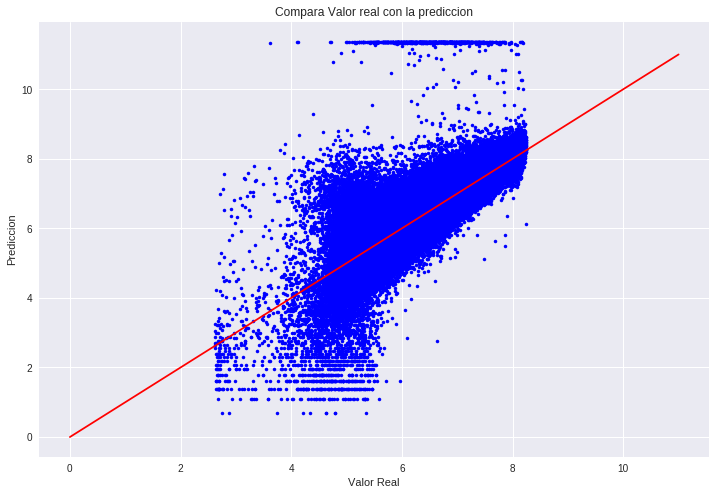

In [52]:
probar_modelo(model,X_train_scaled,y_train,X_val_scaled,y_val)

In [49]:
with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.15))
    #model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

    model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=[error_problema]) #RMSprop, Adam
    history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1,validation_data=(X_val_scaled,y_val))


Train on 1021048 samples, validate on 437592 samples
Epoch 1/20
1021048/1021048 [==============================] - 74s - loss: 0.3562 - error_problema: 0.3780 - val_loss: 0.2368 - val_error_problema: 0.3377
Epoch 2/20
1021048/1021048 [==============================] - 70s - loss: 0.2359 - error_problema: 0.3369 - val_loss: 0.2184 - val_error_problema: 0.3156
Epoch 3/20
1021048/1021048 [==============================] - 62s - loss: 0.2296 - error_problema: 0.3267 - val_loss: 0.2168 - val_error_problema: 0.3111
Epoch 4/20
1021048/1021048 [==============================] - 62s - loss: 0.2294 - error_problema: 0.3229 - val_loss: 0.2156 - val_error_problema: 0.3057
Epoch 5/20
1021048/1021048 [==============================] - 62s - loss: 0.2264 - error_problema: 0.3173 - val_loss: 0.2125 - val_error_problema: 0.2994
Epoch 6/20
1021048/1021048 [==============================] - 63s - loss: 0.2223 - error_problema: 0.3134 - val_loss: 0.2098 - val_error_problema: 0.2952
Epoch 7/20
1021048/1021

ERROR RMSLE de training:  0.432603063624
ERROR RMSLE de validacion:  0.437083997433


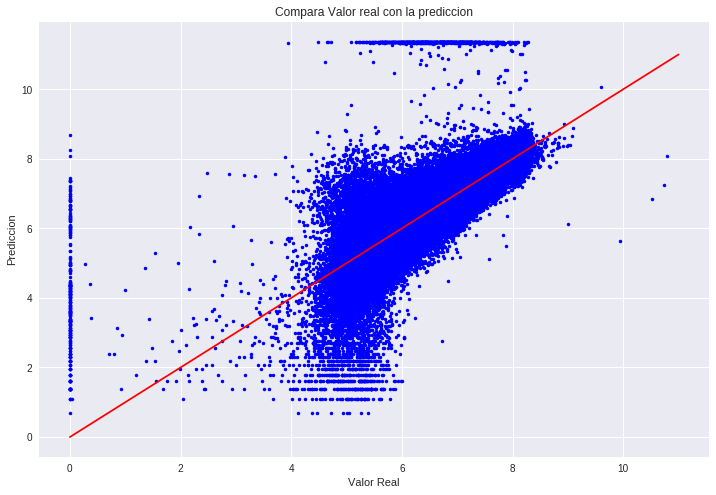

In [50]:
probar_modelo(model,X_train_scaled,y_train,X_val_scaled,y_val)

In [ ]:
##ver cual fue el mejor ...  y entrenarlo abajo (200 epochs)

In [54]:
#transformar a mano el output

with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

    model.compile(optimizer='rmsprop', loss="mse",metrics=[error_problema]) #RMSprop, Adam
    history = model.fit(X_train_scaled, transformar(y_train), epochs=10, batch_size=32, verbose=1,
                        validation_data=(X_val_scaled,transformar(y_val)))

Train on 1021048 samples, validate on 437592 samples
Epoch 1/10
1021048/1021048 [==============================] - 66s - loss: 0.3569 - error_problema: 0.0589 - val_loss: 0.2437 - val_error_problema: 0.0477
Epoch 2/10
1021048/1021048 [==============================] - 62s - loss: 0.2557 - error_problema: 0.0492 - val_loss: 0.2248 - val_error_problema: 0.0447
Epoch 3/10
1021048/1021048 [==============================] - 62s - loss: 0.2340 - error_problema: 0.0462 - val_loss: 0.2180 - val_error_problema: 0.0438
Epoch 4/10
1021048/1021048 [==============================] - 63s - loss: 0.2249 - error_problema: 0.0449 - val_loss: 0.2153 - val_error_problema: 0.0432
Epoch 5/10
1021048/1021048 [==============================] - 63s - loss: 0.2186 - error_problema: 0.0440 - val_loss: 0.2083 - val_error_problema: 0.0423
Epoch 6/10
1021048/1021048 [==============================] - 63s - loss: 0.2131 - error_problema: 0.0431 - val_loss: 0.1991 - val_error_problema: 0.0407
Epoch 7/10
1021048/1021

KeyboardInterrupt: 

 ERROR RMSLE de training:  0.439666902097
ERROR RMSLE de validacion:  0.442904116868


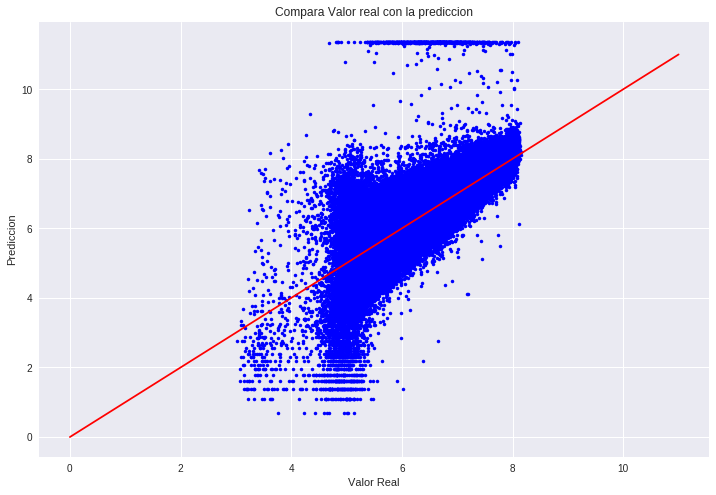

In [57]:
print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled).reshape(1,-1)[0]),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val_scaled).reshape(1,-1)[0]),y_val)

graficar_predicciones(model.predict(X_val_scaled),transformar(y_val))

### Probar con todo el dataset el mejor modelo

In [ ]:
#elegir el mejor entrenarlo por harto rato, ver su grafico y mejorar

#agregar otra capa

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
X_entero_escalado=scaler.fit_transform(X)

with tensorflow.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(250, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(250, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

    model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=[error_problema]) #RMSprop, Adam
    history = model.fit(X_entero_escalado, Y, epochs=200, batch_size=32, verbose=1)
    graficar_historial(history)

print "ERROR RMSLE: ", rmsle( model.predict(X_entero_escalado).reshape(1,-1)[0],Y)

graficar_predicciones(transformar(model.predict(X_entero_escalado)),transformar(Y))

Epoch 1/200
1458640/1458640 [==============================] - 182s - loss: 0.3988 - error_problema: 0.4066   
Epoch 2/200
1458640/1458640 [==============================] - 289s - loss: 0.2157 - error_problema: 0.3142   
Epoch 3/200
1458640/1458640 [==============================] - 186s - loss: 0.2039 - error_problema: 0.3006   
Epoch 4/200
1458640/1458640 [==============================] - 139s - loss: 0.1982 - error_problema: 0.2938   
Epoch 5/200
1458640/1458640 [==============================] - 133s - loss: 0.1941 - error_problema: 0.2890   
Epoch 6/200
1458640/1458640 [==============================] - 129s - loss: 0.1907 - error_problema: 0.2850   
Epoch 7/200
1458640/1458640 [==============================] - 156s - loss: 0.1882 - error_problema: 0.2820   
Epoch 8/200
1458640/1458640 [==============================] - 316s - loss: 0.1865 - error_problema: 0.2799   
Epoch 9/200
1458640/1458640 [==============================] - 162s - loss: 0.1848 - error_problema: 0.2784   
E

## Autoencoder:

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
import tensorflow
with tensorflow.device("/gpu:0"):
    target_dim = 8 #try other and do a nice plot
    input_img = Input(shape=(X_train_scaled.shape[1],))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(target_dim, activation='relu')(encoded2)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded2)
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    encoder = Model(inputs=input_img, outputs=encoded3)

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train_scaled,X_train_scaled,epochs=40,batch_size=100,shuffle=True,
                    validation_data=(X_val_scaled, X_val_scaled),verbose=1)
    autoencoder.save('./modelos_entrenados/my_autoencoder.h5')

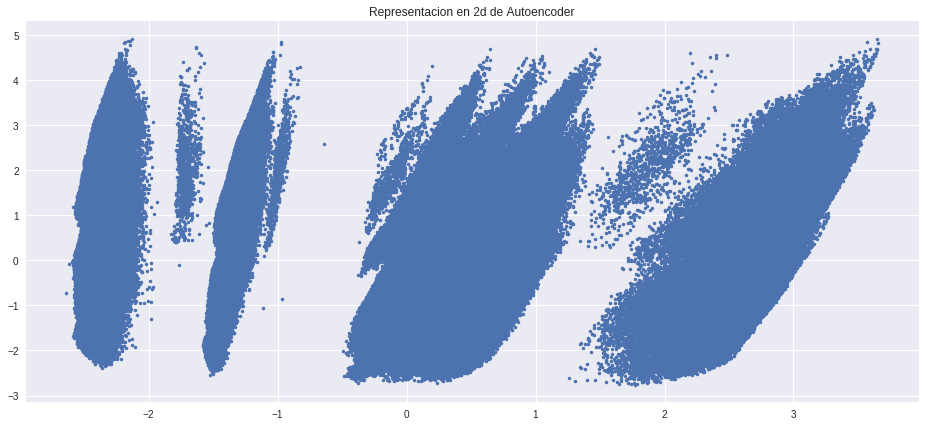

In [23]:
#Reconstruir 
import tensorflow
with tensorflow.device('/cpu:0'):
    autoencoder = load_model('./modelos_entrenados/my_autoencoder.h5')
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-4]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-5].output))

    encoded_train = encoder.predict(X_train_scaled)
    encoded_val = encoder.predict(X_val_scaled)

    model = PCA(n_components=2, random_state=0)
    encoded2d = model.fit_transform(encoded_train)
    encoded2d_val = model.transform(encoded_val)

f, axarr = plt.subplots(1,1, figsize=(16,7))

axarr.plot(encoded2d[:,0], encoded2d[:,1], '.')
axarr.set_title("Representacion en 2d de Autoencoder")
plt.show()

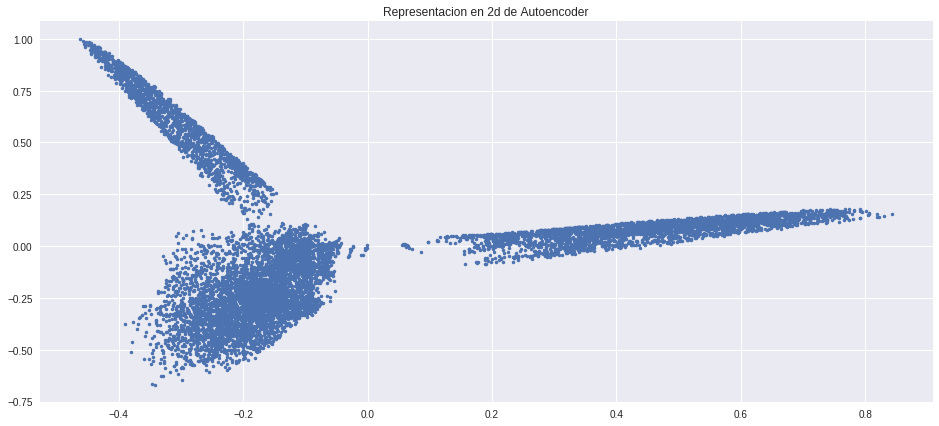

In [30]:
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components=2, random_state=0,n_jobs=-1)

encoded2d = model.fit_transform(encoded_train[:10000])

f, axarr = plt.subplots(1,1, figsize=(16,7))

axarr.plot(encoded2d[:,0], encoded2d[:,1], '.')
axarr.set_title("Representacion en 2d de Autoencoder")
plt.show()

In [31]:
from sklearn.manifold import MDS
model = MDS(n_components = 2,n_jobs=-2)
model.fit(encoded_train[:10000])
encoded2d = model.transform(encoded_train)

f, axarr = plt.subplots(1,1, figsize=(16,7))

axarr.plot(encoded2d[:,0], encoded2d[:,1], '.')
axarr.set_title("Representacion en 2d de Autoencoder")
plt.show()

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/panshop/anaconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/panshop/anaconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7fb5310449b0, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/pansho...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7fb5310449b0, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/pansho...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 20, 5, 31, 16, 43758, tzinfo=tzutc()), u'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', u'msg_type': u'execute_request', u'session': u'6D9CC67AEA484A8881AA2D44EDE25F87', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', 'msg_type': u'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['6D9CC67AEA484A8881AA2D44EDE25F87']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 20, 5, 31, 16, 43758, tzinfo=tzutc()), u'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', u'msg_type': u'execute_request', u'session': u'6D9CC67AEA484A8881AA2D44EDE25F87', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', 'msg_type': u'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['6D9CC67AEA484A8881AA2D44EDE25F87'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 20, 5, 31, 16, 43758, tzinfo=tzutc()), u'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', u'msg_type': u'execute_request', u'session': u'6D9CC67AEA484A8881AA2D44EDE25F87', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'FC283441AE5F44BEAA5B85A71000AAF2', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'from sklearn.manifold import MDS\nmodel = MDS(...epresentacion en 2d de Autoencoder")\nplt.show()', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-31-934ec78a3102>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7fb47aac2e10, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fb4a5459d30, file "<ipython-input-31-934ec78a3102>", line 3>
        result = <ExecutionResult object at 7fb47aac2e10, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fb4a5459d30, file "<ipython-input-31-934ec78a3102>", line 3>, result=<ExecutionResult object at 7fb47aac2e10, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fb4a5459d30, file "<ipython-input-31-934ec78a3102>", line 3>
        self.user_global_ns = {'Adadelta': <class 'keras.optimizers.Adadelta'>, 'Adagrad': <class 'keras.optimizers.Adagrad'>, 'Dense': <class 'keras.layers.core.Dense'>, 'In': ['', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'import scipy.io as sio\nimport scipy as sp\nim...all\nfrom IPython.display import Image as PImage', u'def rmsle(predicted,real):\n    suma=0.0\n    ...a Valor real con la prediccion")\n    plt.show()', u'df = pd.read_csv("train.csv")\ndf_test = pd.read_csv("test.csv")\ndf.info()\ndf_test.info()', u'print("Dimensiones training set: ", df.shape)\nprint("Dimensiones test set: ", df_test.shape)', u'from geopy.distance import great_circle\ndef d...turn (np.degrees( np.arctan2(y,x) ) + 360 ) %360', u'#reemplazar Nan\nfrom pandas.tseries.holiday i...da x: x.cat.codes)\n\npreprocesar(df)\ndf.head()', u"##eliminar 4 puntos outliers claros\ndf = df[(df['trip_duration']<=100000)]", u'all_features = df.columns.values\nprint all_fe...].values\nY = df.loc[:,\'trip_duration\'].values', u'from sklearn.model_selection import train_test...ama\xf1o de dataset de validacion: ",X_val.shape', u'def transformar(valor):\n    return np.log(val...nsformar(model.predict(Xval)),transformar(yval))', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'from sklearn.preprocessing import MinMaxScaler...X_train)\nX_val_scaled = scaler.transform(X_val)', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'import scipy.io as sio\nimport scipy as sp\nim...all\nfrom IPython.display import Image as PImage', u'def rmsle(predicted,real):\n    suma=0.0\n    ...a Valor real con la prediccion")\n    plt.show()', u'df = pd.read_csv("train.csv")\ndf_test = pd.read_csv("test.csv")\ndf.info()\ndf_test.info()', u'print("Dimensiones training set: ", df.shape)\nprint("Dimensiones test set: ", df_test.shape)', u'from geopy.distance import great_circle\ndef d...turn (np.degrees( np.arctan2(y,x) ) + 360 ) %360', ...], 'Input': <function Input>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'MDS': <class 'sklearn.manifold.mds.MDS'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MiniBatchKMeans': <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>, 'Model': <class 'keras.engine.training.Model'>, ...}
        self.user_ns = {'Adadelta': <class 'keras.optimizers.Adadelta'>, 'Adagrad': <class 'keras.optimizers.Adagrad'>, 'Dense': <class 'keras.layers.core.Dense'>, 'In': ['', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'import scipy.io as sio\nimport scipy as sp\nim...all\nfrom IPython.display import Image as PImage', u'def rmsle(predicted,real):\n    suma=0.0\n    ...a Valor real con la prediccion")\n    plt.show()', u'df = pd.read_csv("train.csv")\ndf_test = pd.read_csv("test.csv")\ndf.info()\ndf_test.info()', u'print("Dimensiones training set: ", df.shape)\nprint("Dimensiones test set: ", df_test.shape)', u'from geopy.distance import great_circle\ndef d...turn (np.degrees( np.arctan2(y,x) ) + 360 ) %360', u'#reemplazar Nan\nfrom pandas.tseries.holiday i...da x: x.cat.codes)\n\npreprocesar(df)\ndf.head()', u"##eliminar 4 puntos outliers claros\ndf = df[(df['trip_duration']<=100000)]", u'all_features = df.columns.values\nprint all_fe...].values\nY = df.loc[:,\'trip_duration\'].values', u'from sklearn.model_selection import train_test...ama\xf1o de dataset de validacion: ",X_val.shape', u'def transformar(valor):\n    return np.log(val...nsformar(model.predict(Xval)),transformar(yval))', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'from sklearn.preprocessing import MinMaxScaler...X_train)\nX_val_scaled = scaler.transform(X_val)', u'#Reconstruir \n\nautoencoder = load_model(\'./...epresentacion en 2d de Autoencoder")\nplt.show()', u'import scipy.io as sio\nimport scipy as sp\nim...all\nfrom IPython.display import Image as PImage', u'def rmsle(predicted,real):\n    suma=0.0\n    ...a Valor real con la prediccion")\n    plt.show()', u'df = pd.read_csv("train.csv")\ndf_test = pd.read_csv("test.csv")\ndf.info()\ndf_test.info()', u'print("Dimensiones training set: ", df.shape)\nprint("Dimensiones test set: ", df_test.shape)', u'from geopy.distance import great_circle\ndef d...turn (np.degrees( np.arctan2(y,x) ) + 360 ) %360', ...], 'Input': <function Input>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'MDS': <class 'sklearn.manifold.mds.MDS'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MiniBatchKMeans': <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>, 'Model': <class 'keras.engine.training.Model'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/panshop/Desktop/Competencias KAggle/Datasets/Taxi/<ipython-input-31-934ec78a3102> in <module>()
      1 from sklearn.manifold import MDS
      2 model = MDS(n_components = 2,n_jobs=-2)
----> 3 encoded2d = model.fit_transform(encoded_train[:10000])
      4 
      5 f, axarr = plt.subplots(1,1, figsize=(16,7))
      6 
      7 axarr.plot(encoded2d[:,0], encoded2d[:,1], '.')
      8 axarr.set_title("Representacion en 2d de Autoencoder")
      9 plt.show()

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/manifold/mds.py in fit_transform(self=MDS(dissimilarity='euclidean', eps=0.001, max_it..._init=4, n_jobs=-2, random_state=None, verbose=0), X=array([[ 2.03786206,  2.27824163,  2.17775893, ....        2.64758348,  0.05649674]], dtype=float32), y=None, init=None)
    420         self.embedding_, self.stress_, self.n_iter_ = smacof(
    421             self.dissimilarity_matrix_, metric=self.metric,
    422             n_components=self.n_components, init=init, n_init=self.n_init,
    423             n_jobs=self.n_jobs, max_iter=self.max_iter, verbose=self.verbose,
    424             eps=self.eps, random_state=self.random_state,
--> 425             return_n_iter=True)
    426 
    427         return self.embedding_

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/manifold/mds.py in smacof(dissimilarities=array([[ 0.        ,  2.55873394,  4.69555473, ....        3.31530905,  0.        ]], dtype=float32), metric=True, n_components=2, init=None, n_init=4, n_jobs=-2, max_iter=300, verbose=0, eps=0.001, random_state=<mtrand.RandomState object>, return_n_iter=True)
    261         results = Parallel(n_jobs=n_jobs, verbose=max(verbose - 1, 0))(
    262             delayed(_smacof_single)(
    263                 dissimilarities, metric=metric, n_components=n_components,
    264                 init=init, max_iter=max_iter, verbose=verbose, eps=eps,
    265                 random_state=seed)
--> 266             for seed in seeds)
        seeds = array([1803791388,  218170688, 1146817440, 1801642836])
    267         positions, stress, n_iters = zip(*results)
    268         best = np.argmin(stress)
    269         best_stress = stress[best]
    270         best_pos = positions[best]

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-2), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Aug 20 02:33:28 2017
PID: 6892                 Python 2.7.13: /home/panshop/anaconda2/bin/python
...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _smacof_single>
        args = (memmap([[ 0.        ,  2.55873394,  4.69555473, ...        3.31530905,  0.        ]], dtype=float32),)
        kwargs = {'eps': 0.001, 'init': None, 'max_iter': 300, 'metric': True, 'n_components': 2, 'random_state': 1803791388, 'verbose': 0}
        self.items = [(<function _smacof_single>, (memmap([[ 0.        ,  2.55873394,  4.69555473, ...        3.31530905,  0.        ]], dtype=float32),), {'eps': 0.001, 'init': None, 'max_iter': 300, 'metric': True, 'n_components': 2, 'random_state': 1803791388, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/manifold/mds.py in _smacof_single(dissimilarities=memmap([[ 0.        ,  2.55873394,  4.69555473, ...        3.31530905,  0.        ]], dtype=float32), metric=True, n_components=2, init=None, max_iter=300, verbose=0, eps=0.001, random_state=1803791388)
     65         disparities and the distances for all constrained points).
     66 
     67     n_iter : int
     68         The number of iterations corresponding to the best stress.
     69     """
---> 70     dissimilarities = check_symmetric(dissimilarities, raise_exception=True)
        dissimilarities = memmap([[ 0.        ,  2.55873394,  4.69555473, ...        3.31530905,  0.        ]], dtype=float32)
     71 
     72     n_samples = dissimilarities.shape[0]
     73     random_state = check_random_state(random_state)
     74 

...........................................................................
/home/panshop/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py in check_symmetric(array=memmap([[ 0.        ,  2.55873394,  4.69555473, ...        3.31530905,  0.        ]], dtype=float32), tol=1e-10, raise_warning=True, raise_exception=True)
    671     else:
    672         symmetric = np.allclose(array, array.T, atol=tol)
    673 
    674     if not symmetric:
    675         if raise_exception:
--> 676             raise ValueError("Array must be symmetric")
    677         if raise_warning:
    678             warnings.warn("Array is not symmetric, and will be converted "
    679                           "to symmetric by average with its transpose.")
    680         if sp.issparse(array):

ValueError: Array must be symmetric
___________________________________________________________________________

In [88]:
from sklearn.manifold import TSNE

model = TSNE(n_components = 2)
encoded2d = model.fit_transform(encoded_train[:100000])

f, axarr = plt.subplots(1,1, figsize=(16,7))

axarr.plot(encoded2d[:,0], encoded2d[:,1], '.')
axarr.set_title("Representacion en 2d de Autoencoder")
plt.show()

KeyboardInterrupt: 

### Clusterizar

In [42]:
del df
del df_test
import gc
gc.collect()

46226

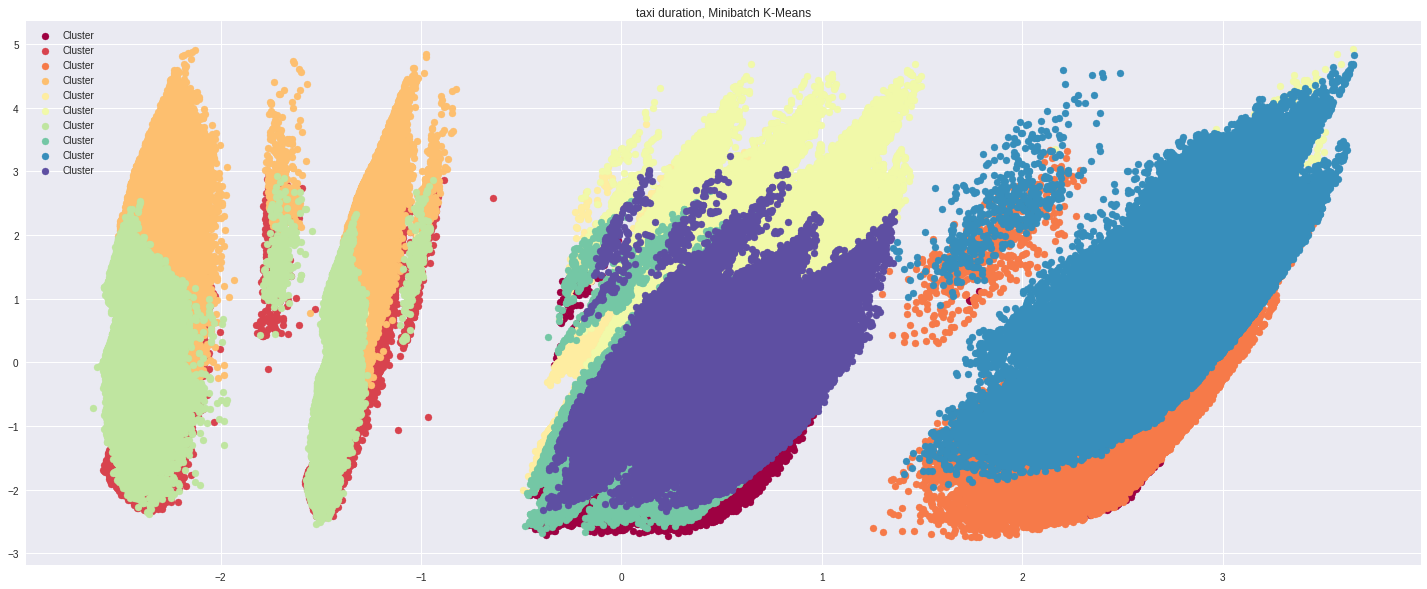

In [46]:
from sklearn.cluster import MiniBatchKMeans
k = 10
minikmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000).fit(X_train_scaled)#encoded2d)
l_pred_mini= minikmeans.labels_
colors = plt.cm.Spectral(np.linspace(0, 1,k ))
    
unique_labels = set(l_pred_mini)
plt.figure(figsize=(25,10))

for etiqueta, col in zip(unique_labels, colors):
    if etiqueta == -1:
        col = 'k'
    class_member_mask = (l_pred_mini == etiqueta)
    xy = encoded2d[class_member_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
    plt.scatter(xy[:,0], xy[:,1], c=col, label="Cluster")
plt.title('taxi duration, Minibatch K-Means')
plt.legend()
plt.show()

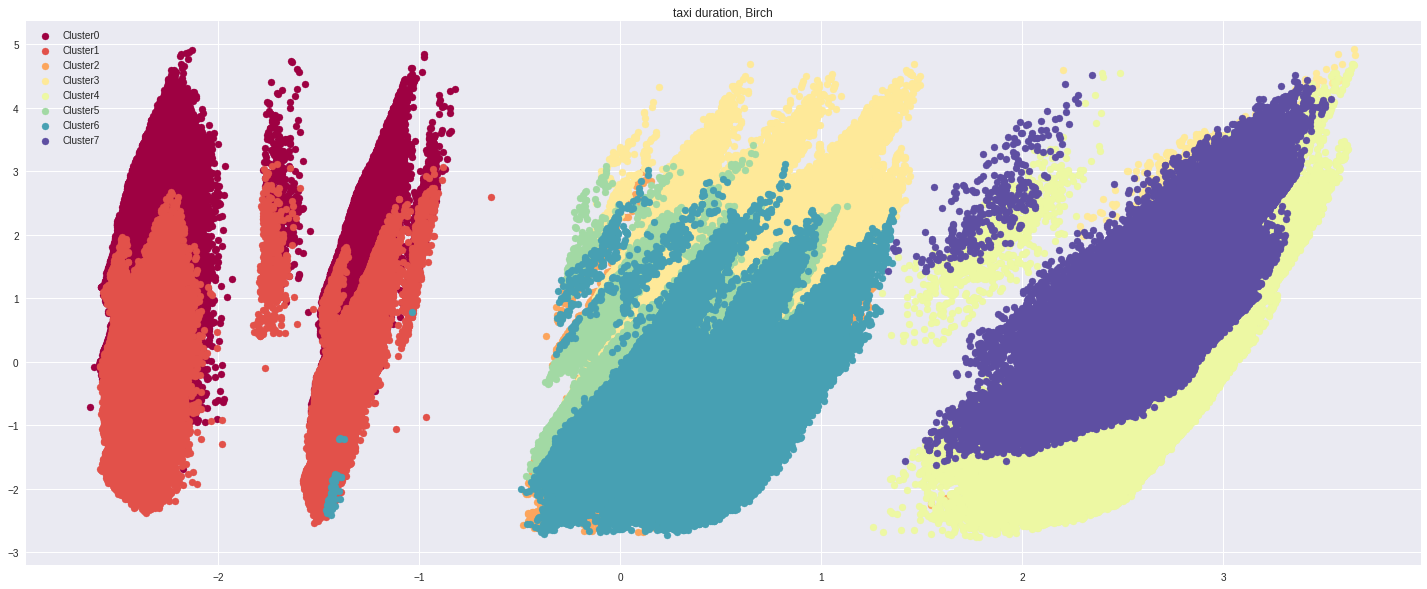

In [44]:
from sklearn.cluster import Birch
brc = Birch(branching_factor=50, n_clusters=8, threshold=0.5,compute_labels=True)
brc.fit(X_train_scaled)
labels= brc.labels_
k=len(set(labels))
colors = plt.cm.Spectral(np.linspace(0, 1, k))

plt.figure(figsize=(25,10))

for etiqueta, col in zip(set(labels), colors):
    if etiqueta == -1:
        col = 'k'
    class_member_mask = (labels == etiqueta)
    xy = encoded2d[class_member_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
    plt.scatter(xy[:,0], xy[:,1], c=col, label="Cluster"+str(etiqueta))
plt.title('taxi duration, Birch')
plt.legend()
plt.show()

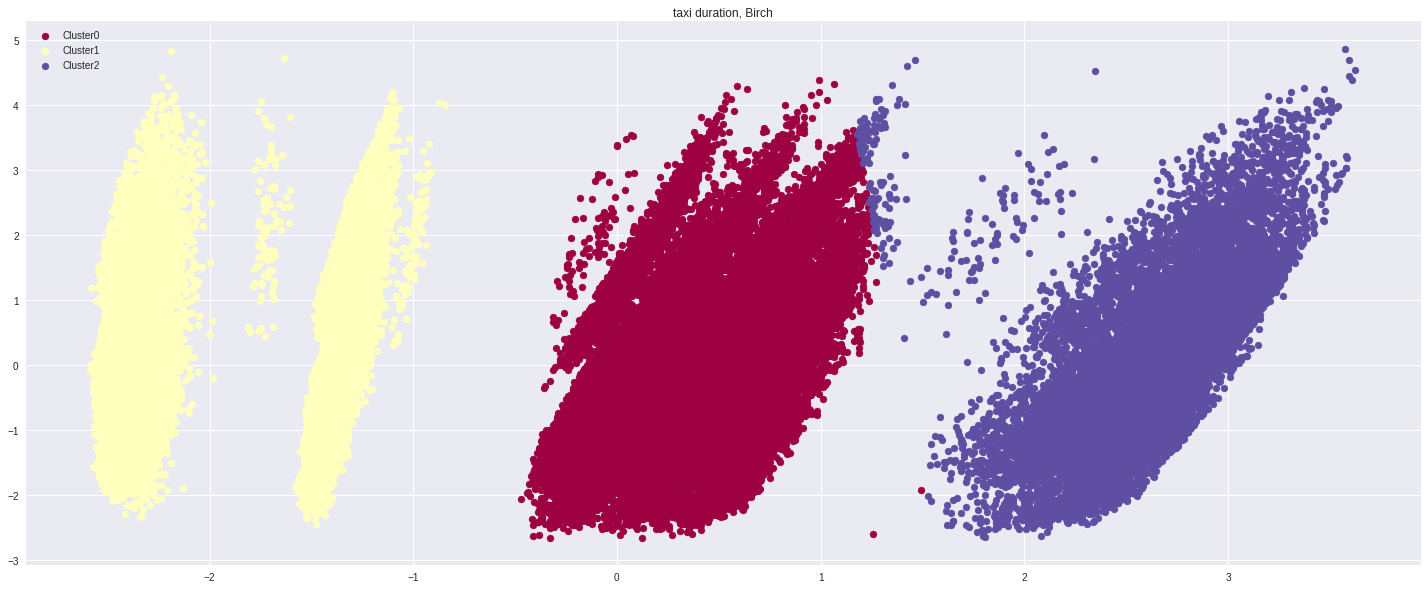

In [39]:
from sklearn.cluster import MeanShift
model = MeanShift(bandwidth=1,bin_seeding=True, cluster_all=True, n_jobs=-1)
sample = encoded2d[:100000]
model.fit(sample)
labels= model.labels_

k=len(set(labels))
colors = plt.cm.Spectral(np.linspace(0, 1, k))

plt.figure(figsize=(25,10))

for etiqueta, col in zip(set(labels), colors):
    if etiqueta == -1:
        col = 'k'
    class_member_mask = (labels == etiqueta)
    xy = sample[class_member_mask]
    plt.scatter(xy[:,0], xy[:,1], c=col, label="Cluster"+str(etiqueta))
plt.title('taxi duration, Birch')
plt.legend()
plt.show()

In [ ]:
#dbscan

In [48]:
etiqueta_cluster_train = minikmeans.predict(X_train_scaled)
etiqueta_cluster_val = minikmeans.predict(X_val_scaled)

In [47]:
etiqueta_cluster_train = brc.predict(encoded2d)
etiqueta_cluster_val = brc.predict(encoded2d_val)

ValueError: Training data and predicted data do not have same number of features.

In [55]:
nuevo_Xtrain = np.concatenate((X_train, etiqueta_cluster_train.reshape(-1,1)), axis=1)
nuevo_Xval = np.concatenate((X_val, etiqueta_cluster_val.reshape(-1,1)), axis=1)

In [ ]:
#reejecutar arriba

In [56]:
from sklearn.ensemble import RandomForestRegressor as RE

profundidades = [5,10,15,20,25,30]
for d in profundidades:
    print "Para la profundidad ",d

    model = RE(max_depth=d,n_jobs=-1)
    model.fit(nuevo_Xtrain,transformar(y_train))

    print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(nuevo_Xtrain)),y_train)
    print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(nuevo_Xval)),y_val)

Para la profundidad  5
ERROR RMSLE de training:  0.506863396706
ERROR RMSLE de validacion:  0.482032409501
Para la profundidad  10
ERROR RMSLE de training:  0.429249983141
ERROR RMSLE de validacion:  0.438062481428
Para la profundidad  15
ERROR RMSLE de training:  0.365078840028
ERROR RMSLE de validacion:  0.419636754633
Para la profundidad  20
ERROR RMSLE de training:  0.276253060662
ERROR RMSLE de validacion:  0.417680534259
Para la profundidad  25
ERROR RMSLE de training:  0.209073559165
ERROR RMSLE de validacion:  0.421040419169
Para la profundidad  30
ERROR RMSLE de training:  0.183521681696
ERROR RMSLE de validacion:  0.423281407545


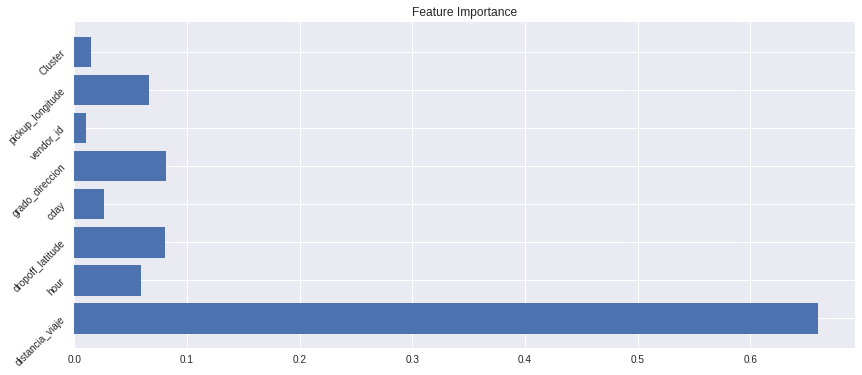

In [57]:
plt.figure(figsize=(14,6))
plt.barh(range(len(nuevas_features)+1), model.feature_importances_)
plt.yticks(range(len(nuevas_features)+1),nuevas_features+["Cluster"], rotation= 45)
plt.title('Feature Importance')
plt.show()